# Training a Machine Learning Classifier for HP-PPI Prediction Task

Classifier: Logistic Regression (`liblinear` solver)
- performs well with sparse variables
- 
- needs no preprocessing

In [1]:
import os
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from hyperopt import hp, tpe, STATUS_OK, Trials, space_eval
from hyperopt.fmin import fmin

from IPython.display import display, Markdown

# Suppress warnings
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.simplefilter('ignore', category=(UndefinedMetricWarning, RuntimeWarning))

In [2]:
# Set up directories
parent_dir = os.path.dirname(os.getcwd())

dir_in = os.path.join(parent_dir, 'data', 'features')
dir_out = os.path.join(parent_dir, 'data', 'results')

In [3]:
# Function for combining datasets
def get_dataset(pathogens):
    '''Combine features and labels of different pathogen datasets'''
    
    X = []
    y = []
    
    # Iterate through datasets
    for pathogen in pathogens:
        f_in = os.path.join(dir_in, '%s_features.pkl' % pathogen)
        X_, y_ = joblib.load(f_in)
        X.append(X_)
        y.append(y_)
    
    # Combine features (X) and labels (y)
    X = sparse.vstack(X)
    y = np.concatenate(y)
    
    return X, y

## Hyperparameter Tuning

Bayesian optimization with `hyperopt`

In [4]:
# Load all datasets
pathogens = ['Bacan', 'Yerpe', 'Fratu']
X, y = get_dataset(pathogens)

# Feature selection
from sklearn.feature_selection import SelectKBest, chi2


In [5]:
# Define objective function
def get_score(params):
    X_ = SelectKBest(chi2, k=params['k']).fit_transform(X, y)
    
    clf = LogisticRegression(C=params['C'],
                             penalty='l1',
                             solver='liblinear',
                             random_state=7)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
    score = cross_val_score(clf, X_, y, cv=cv, scoring='f1', n_jobs=7).mean()
    
    return score

def f(params):
    score = get_score(params)
    return {'loss': -score, 'status': STATUS_OK}

In [6]:
# Define hyperparameter search space
param_space = {'C': hp.uniform('C', 10**-5, 10),
               'k': hp.choice('k', range(1000, 4001))}

# Begin optimization
trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=200, trials=trials)

# Obtain parameters of best model
best_params = space_eval(param_space, best)
best_params

100%|██████████| 200/200 [03:37<00:00,  1.11s/it, best loss: -0.705660717434649]


{'C': 2.6769751811730402, 'k': 3952}

In [7]:
# Set up classifier
clf = LogisticRegression(C=best_params['C'],
                         penalty='l1',
                         solver='liblinear',
                         random_state=7)

X_ = SelectKBest(chi2, k=best_params['k']).fit_transform(X, y)
_ = clf.fit(X_, y)

# Dump model as pickle
_ = joblib.dump(clf, 'best_model.pkl')

## Evaluate model on partitioned datasets

                               Test 1                                
                          Test Pathogen: Bacan
                          
              precision    recall  f1-score   support

           0     0.9030    0.8935    0.8982     10777
           1     0.6011    0.6259    0.6133      2764

    accuracy                         0.8389     13541
   macro avg     0.7521    0.7597    0.7557     13541
weighted avg     0.8414    0.8389    0.8401     13541



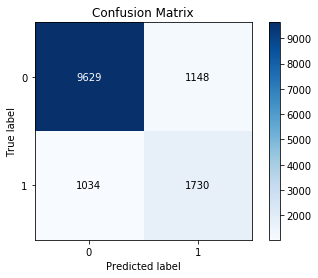

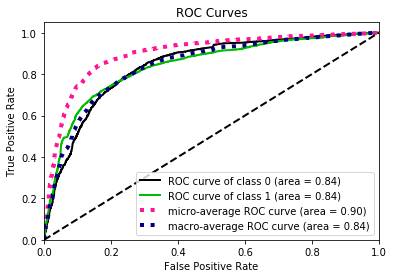

<hr></hr>

                               Test 2                                
                          Test Pathogen: Yerpe
                          
              precision    recall  f1-score   support

           0     0.8866    0.9358    0.9105     13137
           1     0.7052    0.5618    0.6254      3590

    accuracy                         0.8556     16727
   macro avg     0.7959    0.7488    0.7680     16727
weighted avg     0.8476    0.8556    0.8493     16727



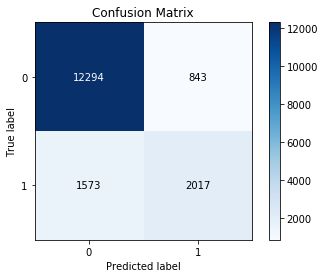

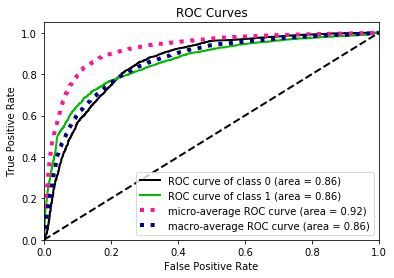

<hr></hr>

                               Test 3                                
                          Test Pathogen: Fratu
                          
              precision    recall  f1-score   support

           0     0.9129    0.9466    0.9294      3500
           1     0.8233    0.7338    0.7759      1187

    accuracy                         0.8927      4687
   macro avg     0.8681    0.8402    0.8527      4687
weighted avg     0.8902    0.8927    0.8906      4687



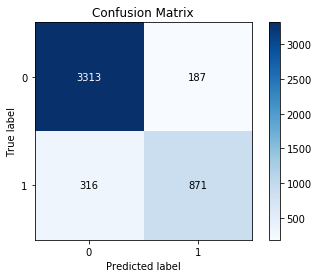

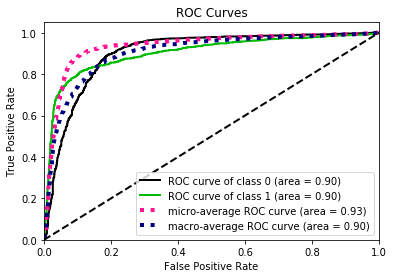

<hr></hr>

In [8]:
# Train and test classifier on different datasets
## Partition datasets by pathogen species
i = 0 # track number of tests

for p_test in pathogens:
    p_train = [p for p in pathogens if p != p_test]
    X_train, y_train = get_dataset(p_train)
    
    # Train classifier
    _ = clf.fit(X_train, y_train)
    
    # Evaluate performance on test set
    X_test, y_test = get_dataset([p_test])
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)
    
    i += 1
    
    print('Test %i'.center(70) % i)
    print('Test Pathogen: %s\n'.center(70) % p_test)
    print(classification_report(y_test, y_pred, digits=4))
    
    # Plot metrics
    _ = plot_confusion_matrix(y_test, y_pred)
    _ = plot_roc(y_test, y_proba)
    _ = plt.show()
    
    display(Markdown('<hr></hr>'))